```{margin} Adaptation!
This work was adapted from lecture notes in John Kitchin's excellent 06-623 course! His lecture notes are included in the helpful resources link if you want to know more details about how numerical methods work.
```

# ODE Integration (with Events!)


`````{admonition} Lecture summary
:class: note
This lecture is going to:
* Quickly review how scipy.integrate.solve_ivp works
* Practice coding up a system of differential equations we covered extensively in 06-262
* Introduce how events works during ODE integrations (useful for future courses!)
* Demonstrate events for a more complicated non-linear higher order differential equation

Along the way, we will:
* Get used to the JupyterLab environment and the structure of the course notes
* Practice plotting in matplotlib
`````

## Review of `scipy.integrate.solve_ivp`

As an example, consider the first order ODE:
\begin{align*}
y' = y + 2x - x^2; y(0) = 1
\end{align*}

This ODE has a known analytical solution: $y(x) = x^2 + e^x$. We will use this for comparison.

The `scipy.integrate` library provides `solve_ivp` to solve first order differential equations. It is not the only one available, but this function is recommended. You import the function like this:

In [1]:
import numpy as np
from scipy.integrate import solve_ivp

Here is a minimal use of the function, with keyword arguments.

`y0` is an array containing the initial values.  `fun` is a function with a signature of f(t, y). Here, $t$ is considered the independent variable. You can call it whatever you want, so f(x, y) is also fine. Since `solve_ivp` had $t$ in mind, the second argument is the `t_span`, which is a tuple of two numbers for where the integration starts (t0, or x0) and where it ends.  `solve_ivp` returns an object.

In [2]:
def f(x, y):
    return y + 2 * x - x**2


x0 = 0
y0 = np.array([1])  # It is a good idea to make y0 an array. It will be important later.

sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0)

The output of `solve_ip` is an object containing results in attributes on the object.

In [3]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.08034384, 0.86683456, 1.5       ])
 t_events: None
        y: array([[1.        , 1.09011474, 3.13086569, 6.73191444]])
 y_events: None

You should look for a few things here. One is that the message indicates success. Second, we access the solution using dot notation. Here are the independent variable values the solution was evaluated at.

In [4]:
sol.t

array([0.        , 0.08034384, 0.86683456, 1.5       ])

Third, the solution is in a 2D array. We only have one equation here, so we use indexing to get the first row as an array.

In [5]:
sol.y[0]

array([1.        , 1.09011474, 3.13086569, 6.73191444])

Now, we can plot the solution.

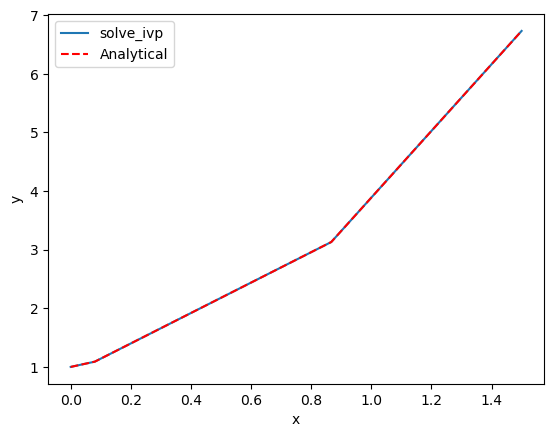

In [6]:
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y[0], label="solve_ivp")
plt.plot(sol.t, sol.t**2 + np.exp(sol.t), "r--", label="Analytical")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

That doesn't looks so great since there are only four data points. By default, the algorithm only uses as many points as it needs to achieve a specified tolerance. We can specify that we want the solution evaluated at other points using the optional `t_eval` keyword arg.

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.03061224, 0.06122449, 0.09183673, 0.12244898,
       0.15306122, 0.18367347, 0.21428571, 0.24489796, 0.2755102 ,
       0.30612245, 0.33673469, 0.36734694, 0.39795918, 0.42857143,
       0.45918367, 0.48979592, 0.52040816, 0.55102041, 0.58163265,
       0.6122449 , 0.64285714, 0.67346939, 0.70408163, 0.73469388,
       0.76530612, 0.79591837, 0.82653061, 0.85714286, 0.8877551 ,
       0.91836735, 0.94897959, 0.97959184, 1.01020408, 1.04081633,
       1.07142857, 1.10204082, 1.13265306, 1.16326531, 1.19387755,
       1.2244898 , 1.25510204, 1.28571429, 1.31632653, 1.34693878,
       1.37755102, 1.40816327, 1.43877551, 1.46938776, 1.5       ])
 t_events: None
        y: array([[1.        , 1.03202273, 1.06688599, 1.10462029, 1.14526069,
        1.18883821, 1.23538386, 1.28493005, 1.33751066, 

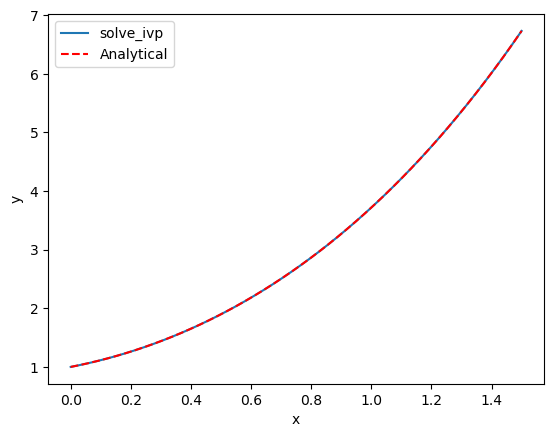

In [7]:
X = np.linspace(x0, 1.5)
sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, t_eval=X)
print(sol)

plt.plot(sol.t, sol.y[0], label="solve_ivp")
plt.plot(X, X**2 + np.exp(X), "r--", label="Analytical")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

`````{admonition} **Tolerances** 
:class: note

solve_ivp is trying to estimate and control the error for you! 
* rtol is the relative tolerance in the function (eg % error in the numbers coming out). 
* atol is the absolute tolerance (I want the concentration +/- 0.00001). 
* rtol is $10^{-3}$ and atols is $10^{-6}$. 
* If your concentration is on the scale of 0.000000001 M, you will have a problem! 
  * Best solution - change units or rescale your problem so your variables are close to 1
  * Possible solution - make you atol really small and hope it solves things
* If decreasing rtol/atol changes your solution, they're not set tightly enough or you have other problems! 
`````

`````{admonition} **Integration failures**  
:class: note

The solve_ivp documentation has some nice comments for what to do it things go wrong with the default RK45 algorithm:

> If not sure, first try to run ‘RK45’. If it makes unusually many iterations, diverges, or fails, your problem is likely to be stiff and you should use ‘Radau’ or ‘BDF’. ‘LSODA’ can also be a good universal choice, but it might be somewhat less convenient to work with as it wraps old Fortran code
`````

## ODE solving strategy review

In 06-262 we spent a lecture talking about how ODE integrators worked. We started with simpler Euler integration and worked our way up through Runge-Kutta, which you coded in one of the homework assignments. As a reminder, the Runge-Kutta update rules were a sequence of calculations that estimated the function value:
\begin{align}
k_1 &= \Delta t \cdot f(t^N, y^N)\\
k_2 &= \Delta t \cdot f\left(t^N+\frac{\Delta t}{2}, y^N + \frac{k_1}{2}\right)\\
k_3 &= \Delta t \cdot f\left(t^N+\frac{\Delta t}{2}, y^N + \frac{k_2}{2}\right)\\
k_4 &= \Delta t \cdot f(t^N+\Delta t, y^N + k_3)\\
y^{N+1} &= y^N + \frac{k_1}{6} + \frac{k_2}{3} + \frac{k_3}{3} +  \frac{k_4}{6}
\end{align}

We can watch how solve_ivp works by using function animations

In [8]:
def wrap_function_save_eval(t, y, function, function_eval_save):
    yp = function(t, y)
    function_eval_save.append((t, y, yp))
    return yp


x0 = 0
y0 = np.array([1])  # It is a good idea to make y0 an array. It will be important later.

# List to contain all of the function evaluations
function_eval_save = []

sol = solve_ivp(
    fun=wrap_function_save_eval, t_span=(x0, 1.5), y0=y0, args=(f, function_eval_save)
)

Now, we'll plot the final solution, as well as the intermediate evaluations as an animation

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation, rc

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

# Add the solution for solve_ivp
ax.plot(sol.t, sol.y.T, "ok--", label="solve_ivp solution")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([0, 2])
ax.set_ylim([0, 10])

# Make a blank line and quiver to hold the data points as they get evaluated
(line,) = ax.plot([], [], "or", label="Function evaluations")
quiver = ax.quiver(x0, y0[0], 1, f(x0, y0)[0], color="r")
ax.legend()

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    
    # unzip the t, y, and yp vectors as separate vectors
    t, y, yp = zip(*function_eval_save)
    
    # Set the data for the line
    line.set_data(t[:i], y[:i])
    
    # Remove the old quiver and make a new one
    global quiver
    quiver.remove()
    quiver = ax.quiver(
        t[:i],
        y[:i],
        np.array(i * [0]) + 1,
        yp[:i],
        color="r",
        angles="xy",
    )
    return (line,)

# Make the animation!
anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=init,
    frames=len(function_eval_save) + 1,
    interval=1000,
    repeat_delay=5000,
    blit=True,
)

# Note: below is the part which helps it work on jupyterbook
rc("animation", html="jshtml")
anim

/opt/conda/lib/python3.9/site-packages/matplotlib/quiver.py:635: RuntimeWarning: Mean of empty slice.
  amean = a.mean()
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


`````{admonition} **Ask yourself these questions when solving ODE's!**
:class: tip

* Is my problem coupled or not? Higher order or not?
* Is my problem stiff? Should I use or do I need a special solver?
* Is there anything I can infer or guess about the solution from the differential  euqations that I can use to check my answers?
* How would I know if I made a mistake?
* Should there be a steady state? If so, how many steady states do I expect? 
* Is the answer reasonable? Do the units make sense?
* If you solve a problem with some tolerance or setting like $\Delta t = 0.1$ (or some other number like atol), always check that your answer does not change with $\Delta t = \frac{0.1}{2}$
* Before solving a problem with numerical methods, make sure you can correctly code the RHS of the equation.
`````

## Practice: Lotka-Volterra  Review of Solving ODEs with Scipy!

As a quick recap of where we left off in 06-262, let's start with an example we spent a lot of time covering, Lotka Volterra (rabbit/wolf) example.

We are interested in how the two populations of species (rabbits and wolves) might change over time. 

* Rabbits are $x(t)$, wolves are $y(t)$
* The rate of rabbits being eaten by wolves is proportional to both ($\beta xy$)
* Rabbits reproduce on their own at a rate proportional to the number of rabbits, and rabbits are eaten by wolves at a rate proportional to the number of rabbits and wolves 
\begin{align*}
\frac{dx}{dt}=\alpha x-\beta xy
\end{align*}
where $\alpha$ and $\beta$ are constants.
* Wolves are able to reproduce at a rate proportional to the number of wolves and rabbits (how quickly rabbits are being eaten) and die at a rate proportional to the number of wolves (sickness/injury/etc) 
\begin{align*}
\frac{dy}{dt}=\delta xy-\gamma y
\end{align*}

Let's say we start with 1 rabbit and 5 wolves, and the constants are 
* $\alpha=1 $[1/day]
* $\beta=0.2$ [1/wolves/day]
* $\delta=0.5$ [1/rabbits/day]
* $\gamma=0.2$ [1/day]

### Solve for and plot the population of rabbits and wolves over the first 20 days

## Using events during ODE integration

So far, `solve_ivp` solves hard differential equations (we did not have to code the algorithm) and handles much of the numerics for us behind the scene. It can also help us solve for the inverse problem. That is, for what value of $x$ is $y=4$?

To do this, we need a new concept of an "event function". During each step of the integration, you can run a function that can detect an "event". When an event is detected, the location of the event is stored, and if desired integration can be terminated. `solve_ivp` can take a list of event functions. We consider only one for now.

An event occurs when an event function is equal to zero. During integration, if the event function changes sign, then it is clear an event has occurred, and the algorithm determines where it occurred. Since we want to know when $y=4$, we will define a function that returns $y - 4$, because that will equal zero at that condition. We want the integration to terminate when that happens, so we set the "terminal" attribute on our function to True.

An event function has a signature of f(x, y). Remember that $y$ is going to be an array,

In [10]:
def event1(x, y):
    return y[0] - 4


event1.terminal = True

sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, events=event1)
sol

  message: 'A termination event occurred.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 1
  success: True
        t: array([0.        , 0.08034384, 0.86683456, 1.05797402])
 t_events: [array([1.05797402])]
        y: array([[1.        , 1.09011474, 3.13086569, 4.        ]])
 y_events: [array([[4.]])]

Now, there are a couple of new things to note. First, we got a message that a termination event occurred. Second, the sol.y array ends at 4.0, because we made the event function *terminal*. Next, sol.t\_events is not empty, because an event occurred. It now contains the value where the event occurred, which is where $y=4$!

In [11]:
sol.t_events[0]

array([1.05797402])

In [12]:
sol.t

array([0.        , 0.08034384, 0.86683456, 1.05797402])

In [13]:
print(f"y=4 at x={sol.t[-1]}. Confirming: y = {sol.t[-1]**2 + np.exp(sol.t[-1])}")

y=4 at x=1.0579740235381916. Confirming: y = 3.999838223738082


That is pretty close. You have to decide if it is close enough for the purpose you want. You can control the tolerance with optional `atol` and `rtol` keywords. You should read the documentation before changing this.

In [14]:
def event1(x, y):
    return y[0] - 4


event1.terminal = True

sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, events=event1, rtol=1e-9)
sol
sol.t[-1] ** 2 + np.exp(sol.t[-1])

3.9999994300847335

We can also control the type of events that are considered by specifying whether the event is triggered in a specific direction. For example, we can find the first occurrence of $y=4$ coming from below

In [15]:
def event1(x, y):
    return y[0] - 4


event1.terminal = True
event1.direction = 1

sol = solve_ivp(fun=f, t_span=(x0, 1.5), y0=y0, events=event1, rtol=1e-9)
sol
sol.t[-1] ** 2 + np.exp(sol.t[-1])

3.9999994300847335

## Summary

In addition to reviewing what we knew from 06-262 on `solve_ivp`, we also talked about how to use **integration events**. These allow us to stop integration at special points. It is very helpful for engineering/design problems.

`````{seealso}
More examples with ODE events are available at {doc}`./ode_events_extra_example`
`````

## Practice continued

### Find the the first occurrence that the rabbit population hits 3

Hint: does it ever hit 3?

### Find the the first occurrence that the wolf population hits 3 while the wolf population is growing